<a href="https://colab.research.google.com/github/Ronan-Castro/Desafio-NVIDIA/blob/main/Desafio_NVIDIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#importações padrões
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from typing import List, Tuple

# Feature importance
from sklearn.inspection import permutation_importance

#tirar warning chatão
import warnings
warnings.filterwarnings('ignore')

#Machine evaluation
from sklearn.metrics import plot_confusion_matrix
#Machine Training
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


#Função para formatar a matriz de correlação
def plot_corr_matrix(corr_matrix, size=(20, 20)):
  # Set up the matplotlib figure
  fig, ax = plt.subplots(figsize=size)

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  # Generate a mask for the upper triangle
  mask = np.triu(np.ones_like(corr_matrix.corr(), dtype=np.bool))

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr_matrix.corr(), mask=mask, cmap=cmap, vmax=.99, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

#Considerações do dataset

- step: representa o total de horas transcorrido desde o início da simulação. Esta feature vai variar entre 1 e 744 em horas(30 dias);

- type: tipo de transação (depósito, saque, débito, pagamento e transferência);

- amount: total que foi transacionado;

- nameOrig: cliente que iniciou a transação

- oldbalanceOrg: saldo da conta de origem antes da transação;

- newbalanceOrig: saldo da conta de origem após a transação;

- nameDest: cliente de destino da transação;

- oldbalanceDest: saldo da conta de destino antes da transação;

- newbalanceDest: saldo da conta de destino após a transação;

- isFraud: flag que define se a transação é fraudulenta ou não. Nesta simulação o objetivo da fraude é assumir a conta do usuário, esvaziá-la transferindo para outra conta e então sacando o dinheiro.

- isFlaggedFraud: automaticamente marcadas pelo banco como fraude por tentarem transferir mais de 200.000 em uma única transação.

***Passos que irei executar na limpeza de dados:***

- Remover os nomes, penso que afetarão pouco ou nada na decisão de fraude
- Tranformar a variável type para OHE
- Balancear o dataset

# Limpeza dos dados

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Desafio_NVIDIA/fraud_detection_dataset.csv", encoding='UTF-8' )

In [ ]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [ ]:
df.query('oldbalanceOrg <  0.9 * amount & isFraud == 0')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
8,1,PAYMENT,4024.36,C1265012928,2671.0,0.0,M1176932104,0.00,0.00,0,0
10,1,DEBIT,9644.94,C1900366749,4465.0,0.0,C997608398,10845.00,157982.12,0,0
13,1,PAYMENT,11633.76,C1716932897,10127.0,0.0,M801569151,0.00,0.00,0,0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.00,51513.44,0,0
16,1,PAYMENT,1563.82,C761750706,450.0,0.0,M1731217984,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362314,718,PAYMENT,17841.23,C1045048098,10182.0,0.0,M1878955882,0.00,0.00,0,0
6362316,718,PAYMENT,1022.91,C1203084509,12.0,0.0,M675916850,0.00,0.00,0,0
6362317,718,CASH_OUT,317177.48,C857156502,170.0,0.0,C784108220,345042.13,662219.61,0,0
6362320,718,CASH_OUT,159188.22,C691808084,3859.0,0.0,C1818183087,0.00,159188.22,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
df.isFlaggedFraud.value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [ ]:
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [ ]:
#df_clean = df.drop(df[['nameOrig', 'nameDest']], axis = 1)
df_clean = df

In [ ]:
types = pd.get_dummies(df_clean['type'])

In [ ]:
data_ohe = pd.concat([df_clean, types], axis = 1)
data_ohe

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,0,0,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,0,0,1,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,0,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0,1,0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,0,1,0,0,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,0,0,0,0,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,0,1,0,0,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,0,0,0,0,1


In [ ]:
dfFinal = data_ohe.drop(['type'], axis=1)

In [ ]:
dfFinal.drop_duplicates(keep=False, inplace=True)

In [ ]:
def transfer_category(x):
    if x >= 75000:
        return('HIGH')
    elif x < 75000 and x >= 14000:
        return('MODERATE')
    elif x < 14000:
        return('LOW')
    else:
        return("EXTREMLY LOW")
dfFinal['transfer_amount_category'] = dfFinal.amount.apply(transfer_category)    
dfFinal.head(2)

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,transfer_amount_category
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,0,0,1,0,LOW
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,0,0,1,0,LOW


In [ ]:
from sklearn.preprocessing import Normalizer, LabelEncoder

In [ ]:
label_encoder = LabelEncoder()

dfFinal['nameOrig_encode'] = label_encoder.fit_transform(dfFinal['nameOrig']) 
dfFinal['nameDest_encode'] = label_encoder.fit_transform(dfFinal['nameDest']) 
dfFinal['transfer_amount_category_encode'] = label_encoder.fit_transform(dfFinal['transfer_amount_category'])

In [ ]:
normalizer = Normalizer()
amount_scale = normalizer.fit_transform(dfFinal.amount.values.reshape(1,-1))
dfFinal['amount_norm'] = amount_scale.reshape(-1,1)
amount_oldbalanceOrg = normalizer.fit_transform(dfFinal.oldbalanceOrg.values.reshape(1,-1))
dfFinal['oldbalanceOrg_norm'] = amount_oldbalanceOrg.reshape(-1,1)
amount_newbalanceOrig = normalizer.fit_transform(dfFinal.newbalanceOrig.values.reshape(1,-1))
dfFinal['newbalanceOrig_norm'] = amount_newbalanceOrig.reshape(-1,1)
amount_oldbalanceDest= normalizer.fit_transform(dfFinal.oldbalanceDest.values.reshape(1,-1))
dfFinal['oldbalanceDest_norm'] = amount_oldbalanceDest.reshape(-1,1)
amount_newbalanceDest = normalizer.fit_transform(dfFinal.newbalanceDest.values.reshape(1,-1))
dfFinal['newbalanceDest_norm'] = amount_newbalanceDest.reshape(-1,1)

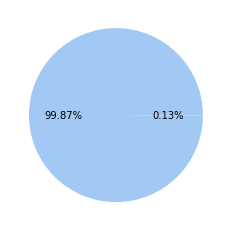

In [ ]:
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

plt.pie(dfFinal.isFraud.value_counts(), colors = colors, autopct='%.2f%%')
plt.show()

In [ ]:
dfFinal.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [ ]:
X = dfFinal[['CASH_IN',	'CASH_OUT',	'DEBIT',	'PAYMENT',	'TRANSFER', 'nameOrig_encode','nameDest_encode',
          'transfer_amount_category_encode','amount_norm',
          'oldbalanceOrg_norm','newbalanceOrig_norm',
          'oldbalanceDest_norm','newbalanceDest_norm']]
y = dfFinal['isFraud']

## UnderSampling

Maneiras de melhorar o oversampling:
- Cluster Centroids

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy=1) # Numerical value
#rus = RandomUnderSampler(sampling_strategy="not minority") # String
X_under, y_under = rus.fit_resample(X, y)

ax = y_under.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")#

In [ ]:
# Class distribution
y_under.value_counts()

## OverSampling

Maneiras de melhorar o oversampling:
- Adasyn
- Smote

In [ ]:
from imblearn.over_sampling import RandomOverSampler

#ros = RandomOverSampler(sampling_strategy=1) # Float
ros = RandomOverSampler(sampling_strategy="not majority") # String
X_over, y_over = ros.fit_resample(X, y)

ax = y_over.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Over-sampling")

In [ ]:
# Class distribution
y_over.value_counts()

In [ ]:
df_oversampled = pd.concat([X_over, y_over], axis = 1)

In [ ]:
df_oversampled

# Analise Exploratória

In [ ]:
corr_matrix = df_oversampled.corr()
plot_corr_matrix(corr_matrix)

Distacam-se as seguintes variáveis em sua correlação ao isFraud:
- step -> Correlação Positiva
- amount -> Correlação Positiva
- CASH_IN -> Correlação Negativa
- PAYMENT -> Correlação Negativa
- TRANSFER -> Correlação Positiva


Vemos também a correlação alta entre as variáveis:
 - oldbalanceOrg e newbalanceOrg
 - oldbalanceDest e newbalanceDest

* Algo que já esperado, uma vez que representa uma conta antes e logo após um deposito/transferencia/pagamento*

In [ ]:
_ = sns.countplot(x="CASH_OUT", data=dfFinal.query('isFraud == 1'))
plt.show()
_ = sns.countplot(x="PAYMENT", data=dfFinal.query('isFraud == 1'))
plt.show()
_ = sns.countplot(x="CASH_IN", data=dfFinal.query('isFraud == 1'))
plt.show()
_ = sns.countplot(x="DEBIT", data=dfFinal.query('isFraud == 1'))
plt.show()
_ = sns.countplot(x="TRANSFER", data=dfFinal.query('isFraud == 1'))

# Modelo de predição dos dados <u>**sem**</u> sampling

## Treino do modelo

In [ ]:
classifier =  DecisionTreeClassifier(max_depth=5)
#classifier =  LogisticRegression(multi_class = 'ovr', penalty ='l1', solver = 'saga')
#classifier = SVC(gamma=2, C=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

In [ ]:
%%time
classifier.fit(X_train, y_train)

CPU times: user 23.7 s, sys: 87.9 ms, total: 23.8 s
Wall time: 24.1 s


DecisionTreeClassifier(max_depth=5)

## Avaliando o modelo

In [ ]:
score = classifier.score(X_test, y_test)
print(f'Acurácia bruta igual à {score:<1.5f}')

Acurácia bruta igual à 0.99921


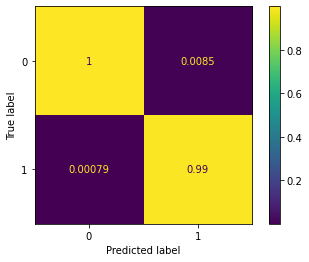

In [ ]:
#matriz de confusão do AdaBoost
plot_confusion_matrix(classifier, X_test, y_test, normalize='pred')  
plt.show() 

# Modelo de predição dos dados <u>***com***</u> oversampling e undersampling

## Treino do modelo com <u>***oversampling***</u>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.33, random_state=42)

In [ ]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

In [ ]:
%%time
classifier.fit(X_train, y_train)

CPU times: user 23.7 s, sys: 87.9 ms, total: 23.8 s
Wall time: 24.1 s


DecisionTreeClassifier(max_depth=5)

## Avaliando o modelo com <u>***oversampling***</u>


In [ ]:
score = classifier.score(X_test, y_test)
print(f'Acurácia bruta igual à {score:<1.5f}')

Acurácia bruta igual à 0.99921


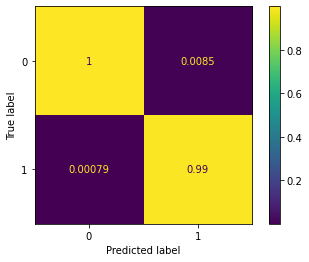

In [ ]:
#matriz de confusão do AdaBoost
plot_confusion_matrix(classifier, X_test, y_test, normalize='pred')  
plt.show() 

## Treino do modelo com <u>***undersampling***</u>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.33, random_state=42)

In [ ]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

In [ ]:
%%time
classifier.fit(X_train, y_train)

CPU times: user 23.7 s, sys: 87.9 ms, total: 23.8 s
Wall time: 24.1 s


DecisionTreeClassifier(max_depth=5)

## Avaliando o modelo com <u>***undersampling***</u>


In [ ]:
score = classifier.score(X_test, y_test)
print(f'Acurácia bruta igual à {score:<1.5f}')

Acurácia bruta igual à 0.99921


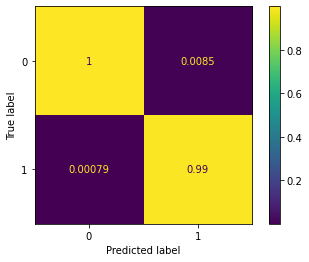

In [ ]:
#matriz de confusão do AdaBoost
plot_confusion_matrix(classifier, X_test, y_test, normalize='pred')  
plt.show() 